# Today we will get familiar with a common architecture named NeuMF. 
The original paper was presented at the WWW conference, and a link to the paper can be found with the following link:
https://arxiv.org/pdf/1708.05031.pdf.

An overview of the architecture suggested can be observed in the following figure:

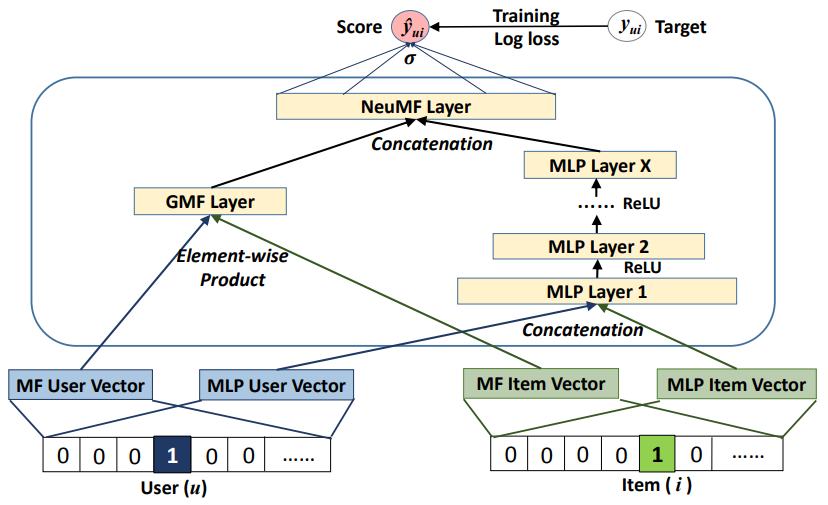

The main advantage of NeuMF is suggesting a neural implementation of the matrix factorization (MF) method.
NeuMF combines the linearity of MF and non-linearity of deep neural networks for modelling user–item latent structures

We will compare the regular SVD implementation from surprise to a Keras implementation of NeuMF

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 8.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617601 sha256=f867c5b6086d2943159327d22ae22762f5d3f14dd3a6eeb41f8e8b73090ce3c6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
from keras.layers import Input,Embedding,Flatten,Dense,Concatenate,Dot,Lambda,Multiply
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split

In [9]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

--2021-05-31 09:07:18--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  8.42MB/s    in 0.6s    

2021-05-31 09:07:19 (8.42 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [11]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [15]:
!ls

ml-100k  ml-100k.zip  ml-1m.zip  sample_data


In [16]:
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')
ratings.drop(columns=['unix_timestamp'],inplace=True)

In [17]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [19]:
num_users = ratings['user_id'].nunique()+1
num_items = ratings['movie_id'].nunique()+1

EMBEDING_SIZE = 32

In [20]:
def get_model(num_users, num_items):
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = EMBEDING_SIZE, name = 'mf_embedding_user',
                                  embeddings_initializer='normal', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = EMBEDING_SIZE, name = 'mf_embedding_item',
                                  embeddings_initializer='normal', input_length=1)

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = EMBEDING_SIZE, name = "mlp_embedding_user",
                                   embeddings_initializer='normal', input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = EMBEDING_SIZE, name = 'mlp_embedding_item',
                                   embeddings_initializer='normal', input_length=1)
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Dot(axes=-1)([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
    
    mlp_dense = Dense(10,activation='relu')(mlp_vector)
    mlp_dense2 = Dense(5,activation='relu')(mlp_dense)
    mlp_dense3 = Dense(3,activation='relu')(mlp_dense2)
    
    predict_vector = Concatenate()([mf_vector, mlp_dense2])
    
    # Final prediction layer
    prediction = Dense(1,activation='sigmoid', name = "prediction")(predict_vector)
    prediction2 = Lambda(lambda x: (x*4)+1)(prediction)
    
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=[prediction2])
    model.compile(optimizer='adam',loss='mse')
    return model

In [21]:
from graphviz import Digraph

In [22]:
trainset, testset = train_test_split(ratings, test_size=.2,shuffle=False)
trainset, validationset = train_test_split(trainset, test_size=.1,shuffle=False)

In [23]:
es = EarlyStopping(min_delta=0.01, patience=3)
mc = ModelCheckpoint(filepath='./model.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)



In [24]:
model = get_model(num_users,num_items)

In [25]:
model.fit(x=[trainset['user_id'],trainset['movie_id']], y=trainset['rating'] ,epochs=10, batch_size= 256,verbose=1)

Epoch 1/10
282/282 [==============================] - 18s 4ms/step - loss: 1.2460
Epoch 2/10
282/282 [==============================] - 1s 4ms/step - loss: 0.8735
Epoch 3/10
282/282 [==============================] - 1s 4ms/step - loss: 0.7989
Epoch 4/10
282/282 [==============================] - 1s 4ms/step - loss: 0.6784
Epoch 5/10
282/282 [==============================] - 1s 4ms/step - loss: 0.5309
Epoch 6/10
282/282 [==============================] - 1s 4ms/step - loss: 0.4207
Epoch 7/10
282/282 [==============================] - 1s 4ms/step - loss: 0.3493
Epoch 8/10
282/282 [==============================] - 1s 4ms/step - loss: 0.3071
Epoch 9/10
282/282 [==============================] - 1s 4ms/step - loss: 0.2739
Epoch 10/10
282/282 [==============================] - 1s 4ms/step - loss: 0.2457


In [26]:
predictions = model.predict(x=[testset['user_id'],testset['movie_id']])

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [28]:
rmse = sqrt(mean_squared_error(y_true=testset['rating'],y_pred=predictions))
print(rmse)

1.0345093230957263


# Code Task
Training this model is done. However, we did not use the validation set and callbacks such as early stopping and model checkpoint. 
Add these callbacks and use the validation set in order to determine when to stop the training process.

In addition, we add a new parameter named 'alpha', this parameter producing a weighted average between the GMF and MLP components of NeuMF. 
Make at least five experiments with different parameters (embedding size, learning rate, etc.') and compare the results of this weighted average version of NeuMF. 

In [ ]:
EMBEDING_SIZE = 
num_users = 
num_items = 
alpha = 
learning_rate = 

In [30]:
# Implement you own version of weigthed NeuMF
#Example of lambda layer: Lambda(lambda x: (1-alpha)*x[0]+alpha*(x[1]))([input_tensor1,input_tensor2])
